In [35]:
# -*- coding: utf-8 -*- 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.datasets import fetch_20newsgroups, load_files
%matplotlib inline

#import sys  
#reload(sys)  
#sys.setdefaultencoding('utf-8')

# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })


In [36]:
train=pd.read_csv('train.csv',sep='\t',encoding='cp1251',parse_dates=['regdt','OrgCreationDate'])
test=pd.read_csv('test.csv',sep='\t',encoding='cp1251',parse_dates=['regdt','OrgCreationDate'])
train.head()

,id,taxactionSystem,regdt,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,OrgCreationDate,documentsCount,cnt_users,is_prolong
0,101969,"УСН, Доходы 6%",1994-03-26,5.0,0.0,0.0,0.0,0,2014-04-12,2.0,0.0,1.0
1,108477,ОСНО,2012-12-05,1.0,0.0,0.0,0.0,0,2014-09-22,5.0,0.0,0.0
2,101476,"УСН, Доходы 6%",2009-11-15,1.0,3.0,3.0,2.0,0,2016-05-04,0.0,0.0,1.0
3,102579,"УСН, Доходы за вычетом расходов 15%",2015-08-09,1.0,0.0,0.0,0.0,0,2015-09-24,0.0,0.0,0.0
4,103110,"УСН, Доходы за вычетом расходов 15%",2015-03-29,0.0,0.0,0.0,0.0,0,2015-03-04,4.0,0.0,0.0


In [37]:
train.drop(axis=0,index=train[train['regdt']=='0001-01-01 00:00:00.0000000']['regdt'].index.values,inplace=True)
train[['regdt','OrgCreationDate']]=train[['regdt','OrgCreationDate']].apply(pd.to_datetime)
train.dropna(axis=0, how='any',inplace=True)

columns = train.select_dtypes(['floating']).columns
train[columns] = train[columns].astype('int64')

train['regdt_year']=pd.DatetimeIndex(train['regdt']).year
train['regdt_month']=pd.DatetimeIndex(train['regdt']).month
train['regdt_day']=pd.DatetimeIndex(train['regdt']).day

train['OrgCreationDate_year']=pd.DatetimeIndex(train['OrgCreationDate']).year
train['OrgCreationDate_month']=pd.DatetimeIndex(train['OrgCreationDate']).month
train['OrgCreationDate_day']=pd.DatetimeIndex(train['OrgCreationDate']).day

train.drop(axis=1,columns=['regdt','OrgCreationDate'],inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7598 entries, 0 to 7625
Data columns (total 16 columns):
id                          7598 non-null int64
taxactionSystem             7598 non-null object
workerCount                 7598 non-null int64
fssdccount                  7598 non-null int64
pfrdcCount                  7598 non-null int64
fnsdcCount                  7598 non-null int64
hasCloudCryptCertificate    7598 non-null int64
documentsCount              7598 non-null int64
cnt_users                   7598 non-null int64
is_prolong                  7598 non-null int64
regdt_year                  7598 non-null int64
regdt_month                 7598 non-null int64
regdt_day                   7598 non-null int64
OrgCreationDate_year        7598 non-null int64
OrgCreationDate_month       7598 non-null int64
OrgCreationDate_day         7598 non-null int64
dtypes: int64(15), object(1)
memory usage: 1009.1+ KB


In [38]:
train.head()

,id,taxactionSystem,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,documentsCount,cnt_users,is_prolong,regdt_year,regdt_month,regdt_day,OrgCreationDate_year,OrgCreationDate_month,OrgCreationDate_day
0,101969,"УСН, Доходы 6%",5,0,0,0,0,2,0,1,1994,3,26,2014,4,12
1,108477,ОСНО,1,0,0,0,0,5,0,0,2012,12,5,2014,9,22
2,101476,"УСН, Доходы 6%",1,3,3,2,0,0,0,1,2009,11,15,2016,5,4
3,102579,"УСН, Доходы за вычетом расходов 15%",1,0,0,0,0,0,0,0,2015,8,9,2015,9,24
4,103110,"УСН, Доходы за вычетом расходов 15%",0,0,0,0,0,4,0,0,2015,3,29,2015,3,4


# Посмотрим на данные

Распределение целевой переменной: 	


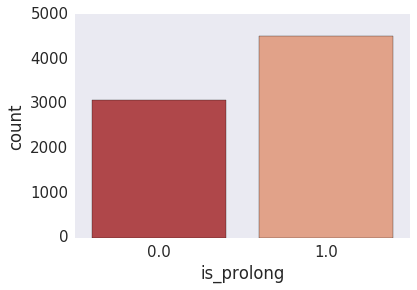

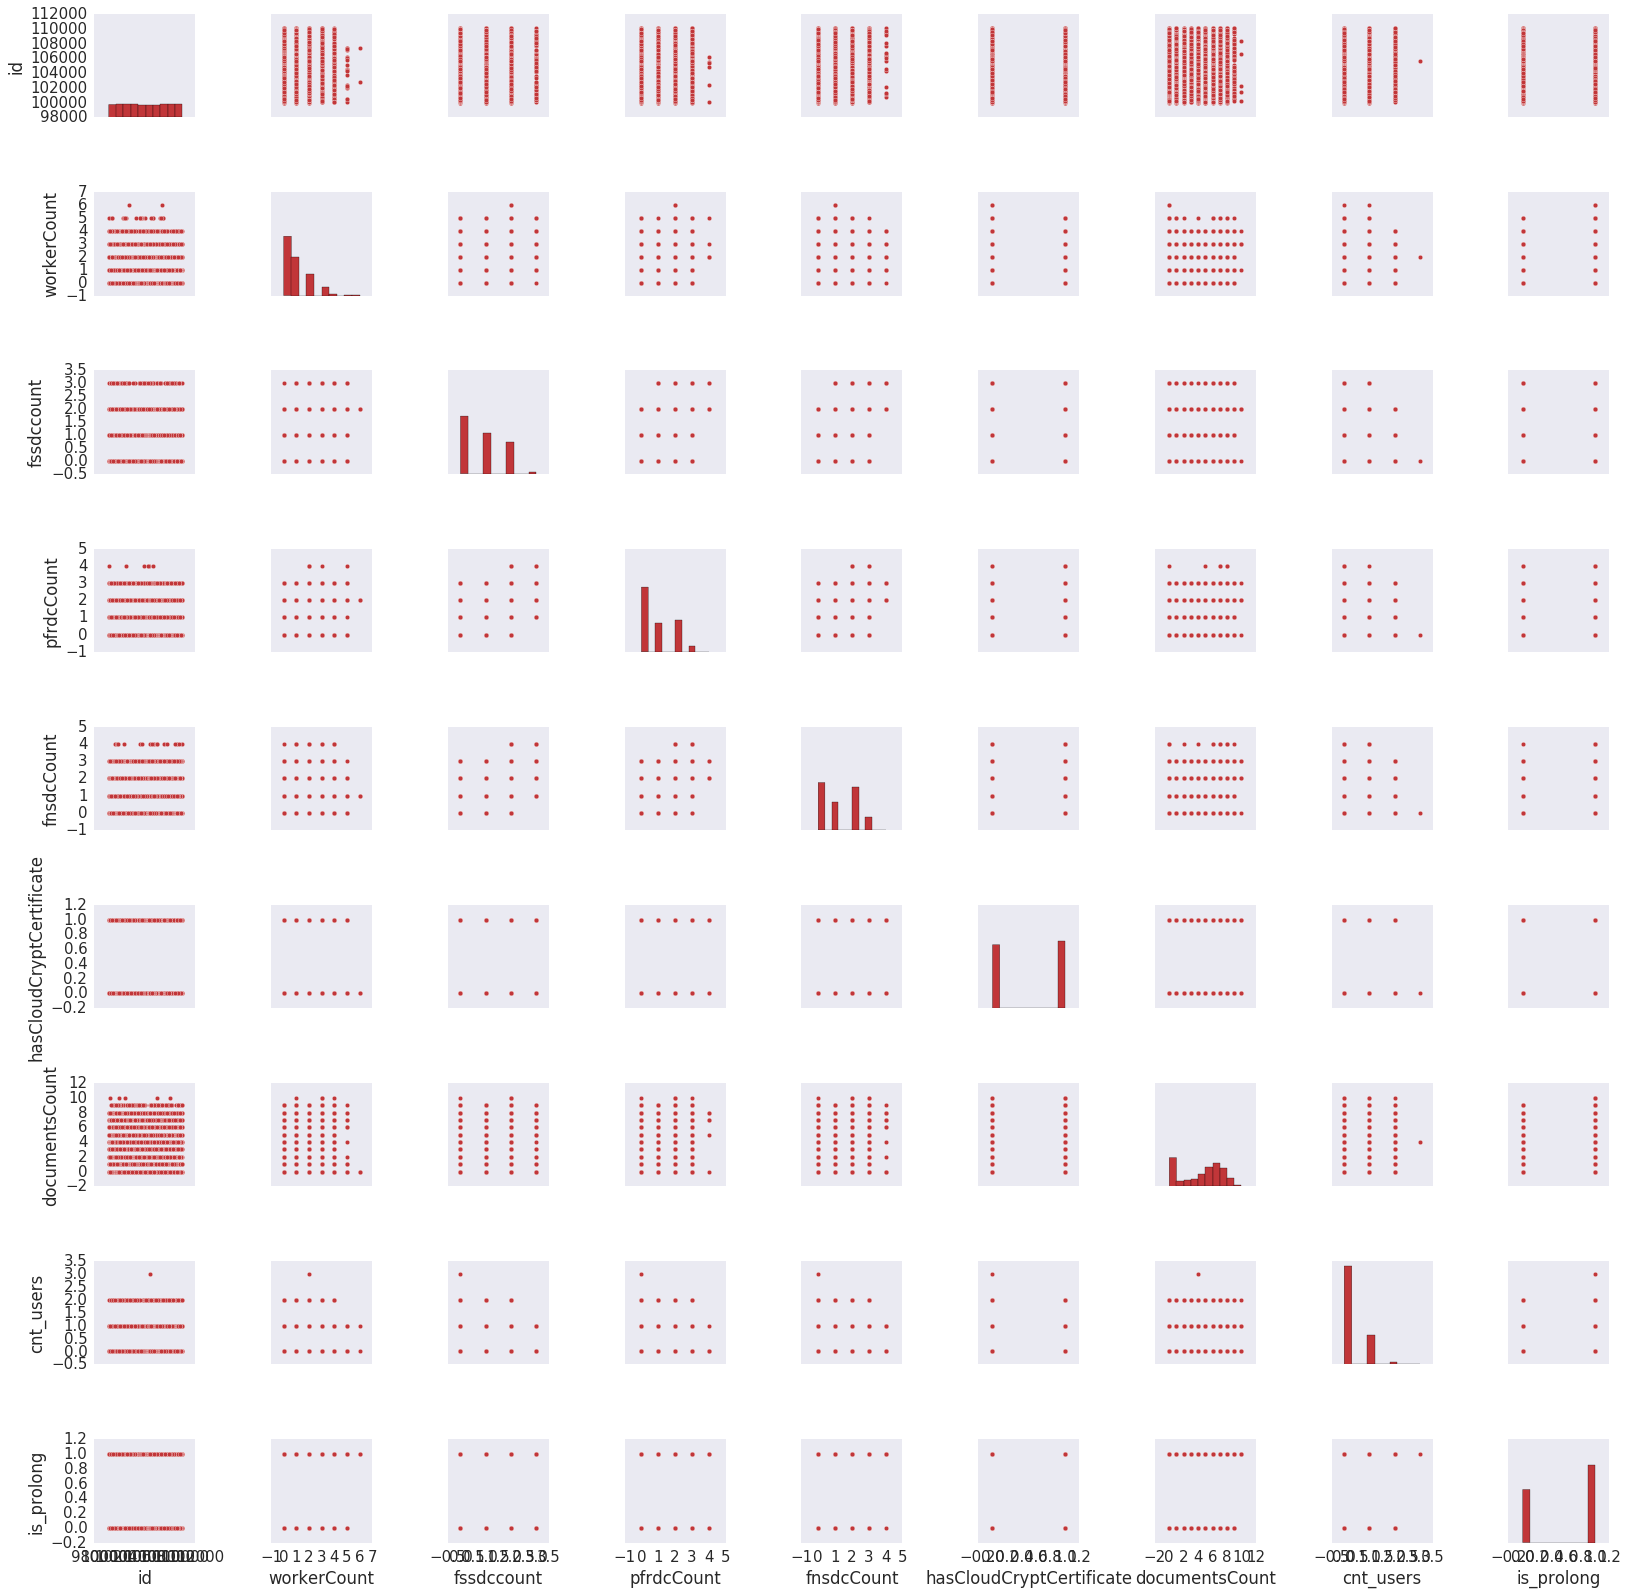

In [4]:
print 'Распределение целевой переменной: \t'
sns.countplot(train.is_prolong)

sns.pairplot(train)

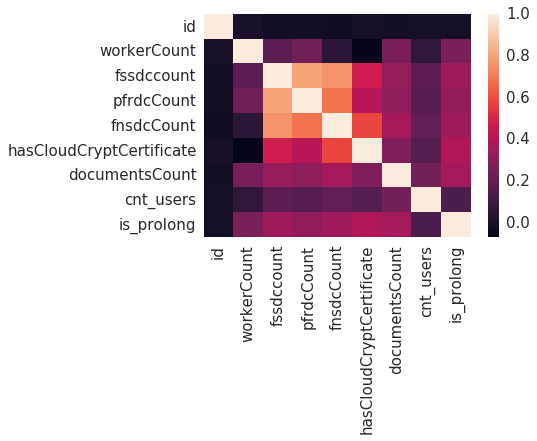

In [5]:
sns.heatmap(train.corr(method='spearman'));

In [6]:
train_y=train.is_prolong
train.drop(axis=1,columns='is_prolong',inplace=True)

## Label Encoding

{0: u'\u0415\u041d\u0412\u0414', 1: u'\u041e\u0421\u041d\u041e', 2: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 3%', 3: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 3% +\u0415\u041d\u0412\u0414', 4: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 4%', 5: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 6%', 6: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 6% +\u0415\u041d\u0412\u0414', 7: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b \u0437\u0430 \u0432\u044b\u0447\u0435\u0442\u043e\u043c \u0440\u0430\u0441\u0445\u043e\u0434\u043e\u0432 10%', 8: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b \u0437\u0430 \u0432\u044b\u0447\u0435\u0442\u043e\u043c \u0440\u0430\u0441\u0445\u043e\u0434\u043e\u0432 10% +\u0415\u041d\u0412\u0414', 9: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b \u0437\u0430 \u0432\u044b\u0447\u0435\u0442\u043e\u043c \u0440\u0430\u0441\u0445\u043e\u0434\u043e\u0432 12%', 10:

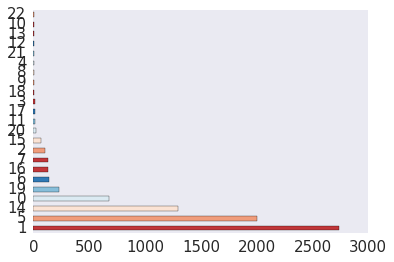

In [7]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(train['taxactionSystem']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [41]:
train['taxactionSystem'] = label_encoder.fit_transform(train['taxactionSystem']).astype('int')
train.head()

,id,taxactionSystem,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,documentsCount,cnt_users,is_prolong,regdt_year,regdt_month,regdt_day,OrgCreationDate_year,OrgCreationDate_month,OrgCreationDate_day
0,101969,5,5,0,0,0,0,2,0,1,1994,3,26,2014,4,12
1,108477,1,1,0,0,0,0,5,0,0,2012,12,5,2014,9,22
2,101476,5,1,3,3,2,0,0,0,1,2009,11,15,2016,5,4
3,102579,14,1,0,0,0,0,0,0,0,2015,8,9,2015,9,24
4,103110,14,0,0,0,0,0,4,0,0,2015,3,29,2015,3,4


## StandardScaler

In [43]:
scaler=StandardScaler()
train_sc=scaler.fit_transform(train)